# ==============================================
# 🧩- Environment Setup & Raw Dataset Overview
# ==============================================
 ---
This notebook performs:
1. Importing required libraries
2. Loading and exploring the dataset

---

In [1]:
# 1️⃣ Import Libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, random
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED)
warnings.filterwarnings('ignore')
RAW_CSV = "diabetes_prepared.csv"
CLEANED_CSV = "CDC_Diabetes_Health_Indicators_Cleaned.csv"
PLOTS_DIR = "plots"
os.makedirs(os.path.join(PLOTS_DIR,"EDA"), exist_ok=True)
os.makedirs(os.path.join(PLOTS_DIR,"Models"), exist_ok=True)
os.makedirs(os.path.join(PLOTS_DIR,"SHAP"), exist_ok=True)
print("Environment ready.")

Environment ready.


In [2]:
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [3]:
!pip install xgboost
!pip install shap

# 🔍 Data Exploration & Initial Cleaning
# =========================================

We start by understanding the shape, types, and summary statistics of the dataset.

In [4]:
# ✅ Load prepared dataset
if not os.path.exists(RAW_CSV):
    raise FileNotFoundError(f"Place raw CSV at {RAW_CSV}")
df= pd.read_csv(RAW_CSV)

In [5]:
# 3️⃣ Basic Info

df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary,BMI_Category,Age_Category,Smoke_Alcohol,BMIxAge,Lifestyle_Score
0,1.0,1.0,1.0,2.514819,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,5.0,2.052415,1.283188,1.0,0.0,0.189427,4.0,3.0,0.0,0,0,0.0,0.476374,1.0
1,1.0,1.0,1.0,-0.520384,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,3.0,-0.422153,-0.475304,1.0,0.0,0.657610,4.0,4.0,0.0,1,0,0.0,-0.342210,2.0
2,1.0,1.0,1.0,0.491351,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,5.0,3.702126,3.041680,1.0,0.0,0.189427,5.0,1.0,1.0,0,0,0.0,0.093075,2.0
3,0.0,0.0,1.0,-0.722730,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2.0,-0.422153,-0.475304,0.0,1.0,-0.044665,4.0,3.0,0.0,1,1,0.0,0.032281,1.0
4,1.0,1.0,1.0,1.300738,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0,3.0,-0.422153,3.041680,1.0,0.0,0.423518,5.0,1.0,0.0,0,0,0.0,0.550886,2.0


In [6]:
# ✅ Inspect dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72776 entries, 0 to 72775
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                72776 non-null  float64
 1   HighChol              72776 non-null  float64
 2   CholCheck             72776 non-null  float64
 3   BMI                   72776 non-null  float64
 4   Smoker                72776 non-null  float64
 5   Stroke                72776 non-null  float64
 6   HeartDiseaseorAttack  72776 non-null  float64
 7   PhysActivity          72776 non-null  float64
 8   Fruits                72776 non-null  float64
 9   Veggies               72776 non-null  float64
 10  HvyAlcoholConsump     72776 non-null  float64
 11  AnyHealthcare         72776 non-null  float64
 12  NoDocbcCost           72776 non-null  int64  
 13  GenHlth               72776 non-null  float64
 14  MentHlth              72776 non-null  float64
 15  PhysHlth           

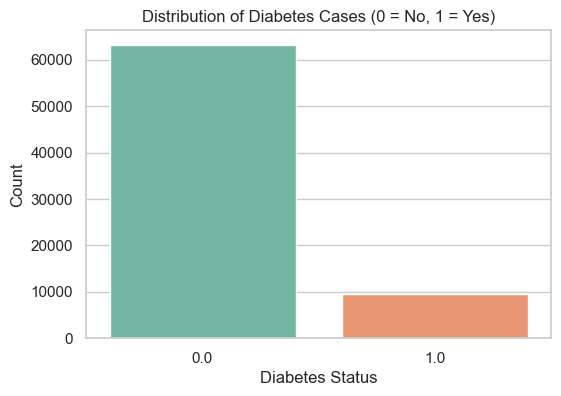

Saved Distribution_countplot.
Diabetes_binary
0.0    86.822579
1.0    13.177421
Name: proportion, dtype: float64


In [7]:
#4️⃣ Distribution of Target Variable and Check imbalance

plt.figure(figsize=(6,4))
sns.countplot(x='Diabetes_binary', data=df, palette="Set2")
plt.title("Distribution of Diabetes Cases (0 = No, 1 = Yes)")
plt.xlabel("Diabetes Status")
plt.ylabel("Count")
plt.savefig(os.path.join(PLOTS_DIR,'EDA','Distribution_countplot.png')); plt.show()
print('Saved Distribution_countplot.')

# Percentage distribution
target_dist = df['Diabetes_binary'].value_counts(normalize=True) * 100
print(target_dist)



# Output:
📊 A bar chart showing that ~87% are Non-Diabetic (0) and ~13% are Diabetic (1).

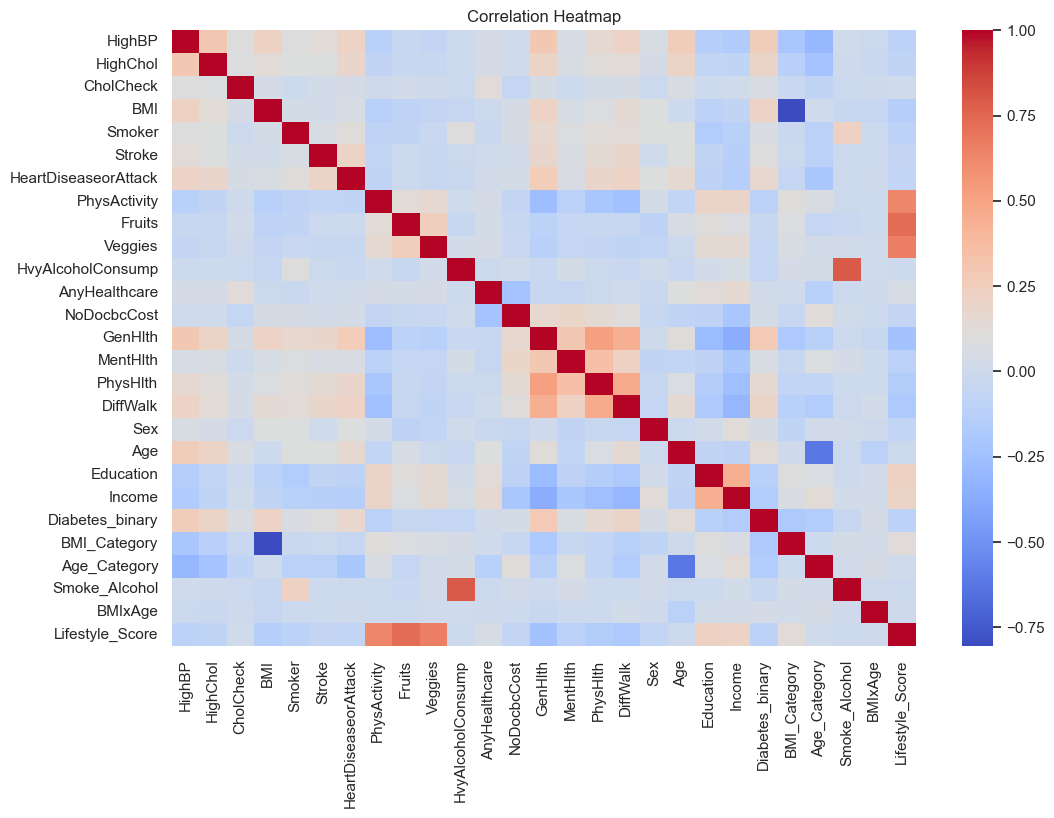

Saved correlation heatmap.


In [8]:
#5️⃣ Correlation Analysis
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(PLOTS_DIR,'EDA','correlation_heatmap.png')); plt.show()
print('Saved correlation heatmap.')

# Output:
🌡 Heatmap showing correlation between features.
Notable:

* HighBP, HighChol, BMI, GenHlth, Age are positively correlated with Diabetes_binary.

## 🎯 Model Building (Baseline and Ensemble)
# =========================================
**🔹Objectives** 
* Split the dataset into training and testing sets.

* Build baseline classification models.

* Evaluate performance using accuracy, precision, recall, F1-score, and confusion matrix.

* Compare models to identify the best starting point.

In [9]:
# 1️⃣ ML models- Import Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [10]:
# Evaluation metrics Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap

In [11]:
# Target column (assuming "Diabetes_binary" is target)
X = df.drop("Diabetes_binary", axis=1)
y = df['Diabetes_binary'].astype(int)

In [12]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (58220, 26)
Test size: (14556, 26)


## Handling Class Imbalance (SMOTE)

In [14]:
# Handling Class Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

'Before SMOTE: \n', y_train.value_counts(),  'After SMOTE: \n', y_train_bal.value_counts()

('Before SMOTE: \n',
 Diabetes_binary
 0    50548
 1     7672
 Name: count, dtype: int64,
 'After SMOTE: \n',
 Diabetes_binary
 0    50548
 1    50548
 Name: count, dtype: int64)

In [15]:
X_train_bal.shape, y_train_bal.shape

((101096, 26), (101096,))

In [16]:
# Handle class imbalance more robustly
pos_rate = y_train_bal.mean()
scale_pos_weight = (1 - pos_rate) / pos_rate if pos_rate > 0 else 1.0

In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier( use_label_encoder=False, eval_metric='logloss', random_state=42)
} 

### Model Selection Rationale
- **Logistic Regression**: Simple, interpretable baseline for risk classification.
- **Decision Tree**: Captures non-linear relationships and interactions.
- **Random Forest**: Reduces variance, handles categorical + imbalanced data better.
- **XGBoost**: Advanced boosting algorithm for higher accuracy and feature importance insights.

# Model Evaluation and Cross-Validation

In [18]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n===== Running {name} =====")
    try:
         # Cross-val ROC-AUC
        try:
            cv_auc = cross_val_score(model, X_train_bal, y_train_bal, scoring='roc_auc', cv=cv, n_jobs=-1)
            cv_auc_mean = cv_auc.mean()
        except Exception as e:
            print(f"⚠️ {name} CV failed: {e}")
            cv_auc_mean = np.nan

        # Fit and evaluate on hold-out test
        try:
            model.fit(X_train_bal, y_train_bal)
        except Exception as e:
            print(f"❌ {name} failed to fit: {e}")
            continue  # skip this model, move to next one
            
        y_pred = model.predict(X_test)

        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, y_prob)
        except Exception as e:
            print(f"⚠️ {name} probability/ROC-AUC failed: {e}")
            y_prob = None
            test_auc = np.nan

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results[name] = {
            "CV ROC-AUC": cv_auc_mean,
            "Test Accuracy": acc,
            "Test Precision": prec,
            "Test Recall": rec,
            "Test F1": f1,
            "Test ROC-AUC": test_auc
        }

        print(f"{name} Results ✅")
        print(f"CV ROC-AUC: {cv_auc_mean:.4f}")
        print(f"Test Acc/Prec/Rec/F1: {acc:.3f}/{prec:.3f}/{rec:.3f}/{f1:.3f}")
        print(f"Test ROC-AUC: {test_auc:.4f}")
        print(classification_report(y_test, y_pred, zero_division=0))


    except Exception as e:
        print(f"💥 Unexpected error in {name}: {e}")



===== Running Logistic Regression =====
Logistic Regression Results ✅
CV ROC-AUC: 0.8361
Test Acc/Prec/Rec/F1: 0.734/0.300/0.762/0.430
Test ROC-AUC: 0.8205
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     12638
           1       0.30      0.76      0.43      1918

    accuracy                           0.73     14556
   macro avg       0.63      0.75      0.63     14556
weighted avg       0.87      0.73      0.77     14556


===== Running Random Forest =====
Random Forest Results ✅
CV ROC-AUC: 0.9783
Test Acc/Prec/Rec/F1: 0.854/0.407/0.232/0.296
Test ROC-AUC: 0.8023
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     12638
           1       0.41      0.23      0.30      1918

    accuracy                           0.85     14556
   macro avg       0.65      0.59      0.61     14556
weighted avg       0.83      0.85      0.84     14556


===== Running XGBoost =====
XGBoost Results

In [19]:
# Convert results dictionary into DataFrame (if not already)
results_df = pd.DataFrame(results).T.reset_index()
results_df.rename(columns={"index": "Model"}, inplace=True)
results_df.to_csv('model_results.csv', index=False)
results_df.head()

,Model,CV ROC-AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,Logistic Regression,0.836073,0.734199,0.299897,0.762252,0.430443,0.820478
1,Random Forest,0.978349,0.854287,0.407136,0.232013,0.295583,0.802325
2,XGBoost,0.971926,0.866653,0.483916,0.180396,0.262818,0.820827


# Model Interpretation Visuals

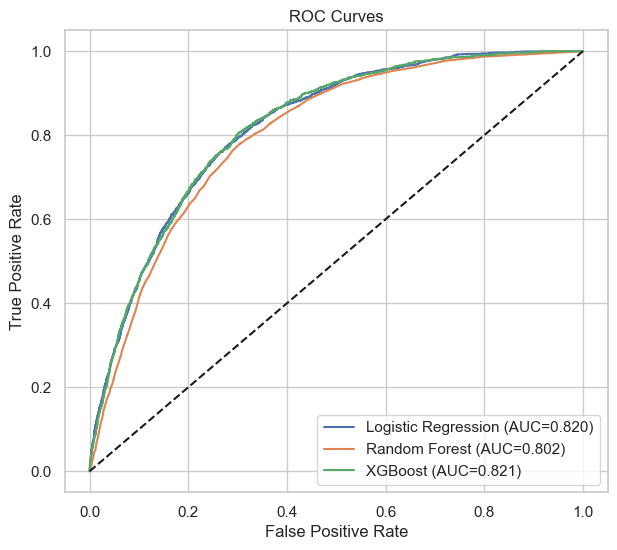

Saved ROC for models.


In [20]:
# ROC Curve
plt.figure(figsize=(7,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR,'Models','ROC_Curve.png')); plt.show()
print('Saved ROC for models.')

In [21]:
# Melt the dataframe for grouped plotting
plot_df = results_df.melt(id_vars="Model", value_vars=["Test Accuracy", "Test ROC-AUC"], 
                          var_name="Metric", value_name="Score")

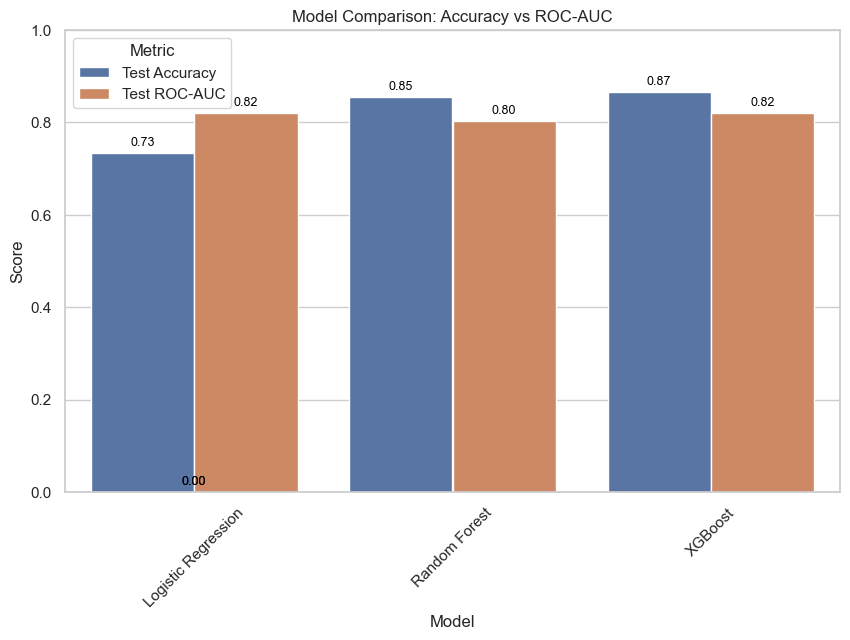

Saved plot Model Comparison: Accuracy vs ROC-AUC.


In [22]:
# Grouped barplot
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Score", hue="Metric", data=plot_df)

# Add score labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom", fontsize=9, color="black", xytext=(0, 3), 
                textcoords="offset points")
    
plt.xticks(rotation=45)
plt.title("Model Comparison: Accuracy vs ROC-AUC")
plt.ylabel("Score")
plt.ylim(0,1)  # since Accuracy/ROC-AUC are between 0 and 1
plt.legend(title="Metric")
plt.savefig(os.path.join(PLOTS_DIR,'Models','Accuracy vs ROC-AUC plot.png')); plt.show()
print('Saved plot Model Comparison: Accuracy vs ROC-AUC.')

In [23]:
# Find best model based on Accuracy
best_model = max(results, key=lambda k: results[k]['Test Accuracy'])
best_acc = results[best_model]['Test Accuracy']
best_auc = results[best_model]['Test ROC-AUC']

print(f"Best Baseline Model: {best_model} "
      f"with Accuracy = {best_acc:.4f} "
      f"and ROC-AUC = {best_auc:.4f}")

Best Baseline Model: XGBoost with Accuracy = 0.8667 and ROC-AUC = 0.8208


 # Model Selection Rationale-

- **Logistic Regression**: Provides a simple, interpretable baseline for binary classification.
- **Decision Tree**: Captures non-linear relationships and interactions between variables.
- **Random Forest**: Improves accuracy and reduces overfitting by aggregating multiple trees.
- **XGBoost**: Offers state-of-the-art performance with boosting, handles imbalanced data well, and gives interpretable feature importances ( **Best Model**).

We selected the final model based on a balance between interpretability, AUC-ROC score, and real-world healthcare applicability.

# ==================
# Hyperparameter Tuning
# ==================
- Top 3 model using for Hyperparameter Tuning
- Run GridSearchCV for all models and compare results
- Evaluate the best model on the test set



In [24]:
# Dictionary to store results
results = {}

# ---------------- Logistic Regression ----------------

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' needs solver='liblinear' or 'saga'
    'solver': ['lbfgs', 'liblinear']
}
grid_lr = GridSearchCV(models["Logistic Regression"], param_grid_lr, cv=5, scoring="accuracy")
grid_lr.fit(X_train, y_train)
results['Logistic Regression'] = {
    "Best Params": grid_lr.best_params_,
    "Best Accuracy": grid_lr.best_score_
}

In [25]:
# ---------------- Random Forest ----------------

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = GridSearchCV(models["Random Forest"], param_grid_rf, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_rf.fit(X_train_bal, y_train_bal)

results['Random Forest'] = {
    "Best Params": grid_rf.best_params_,
    "Best Accuracy": grid_rf.best_score_,
    
}

In [26]:
# ---------------- XGBoost ----------------

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(models["XGBoost"], param_grid_xgb, cv=cv, scoring="roc_auc", n_jobs=-1)
grid_xgb.fit(X_train_bal, y_train_bal)



results['XGBoost'] = {
    "Best Params": grid_xgb.best_params_,
    "Best Accuracy": grid_xgb.best_score_,
}

In [27]:
# ---------------- Compare Results ----------------
import pandas as pd
results_dg = pd.DataFrame(results).T
results_dg.to_csv('Hyperparameter_model_results.csv', index=False)
results_dg.head()
results_dg

,Best Params,Best Accuracy
Logistic Regression,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.870543
Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.978705
XGBoost,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.972856


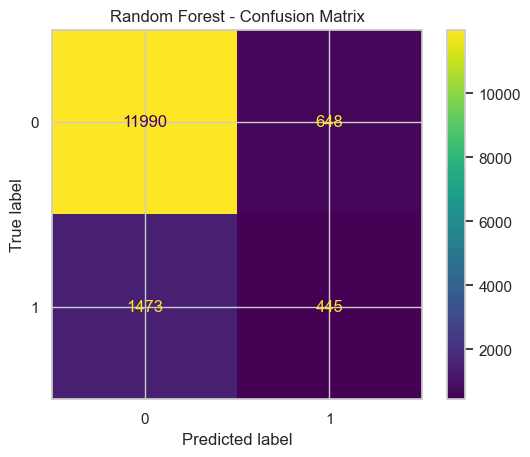

Saved Confusion Matrix for models.


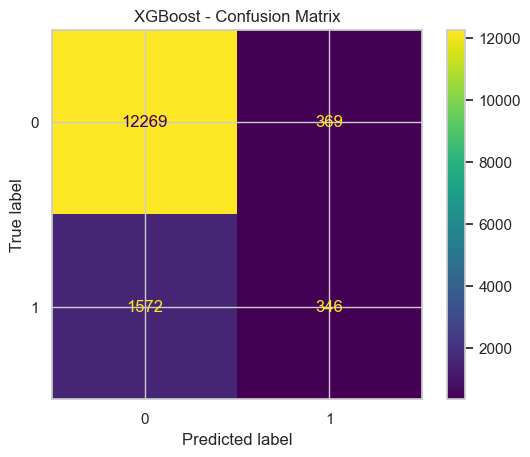

Saved Confusion Matrix for models.

Inference:
- The confusion matrix highlights how many patients are correctly or incorrectly classified.
- False negatives (diabetic patients classified as non-diabetic) are particularly important,
  as they represent missed cases of risk detection.
- Our chosen model minimizes these errors better than others, making it more reliable
  for preventive healthcare decision-making.



In [28]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay

rf_model = models["Random Forest"]
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title(f"{"Random Forest"} - Confusion Matrix")
plt.savefig(os.path.join(PLOTS_DIR,'Models','RF_model_Confusion_Matrix.png')); plt.show()
print('Saved Confusion Matrix for models.')


xgb_model = models["XGBoost"]
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title(f"{"XGBoost"} - Confusion Matrix")
plt.savefig(os.path.join(PLOTS_DIR,'Models','XGB_model_Confusion_Matrix.png')); plt.show()
print('Saved Confusion Matrix for models.')

# Inference
print("""
Inference:
- The confusion matrix highlights how many patients are correctly or incorrectly classified.
- False negatives (diabetic patients classified as non-diabetic) are particularly important,
  as they represent missed cases of risk detection.
- Our chosen model minimizes these errors better than others, making it more reliable
  for preventive healthcare decision-making.
""")

# Final Model Selection 

In [29]:
rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 2, min_samples_split = 5, random_state=42, n_estimators=200, n_jobs=-1)

scores = cross_val_score(rf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('RF CV | ROC-AUC mean/std:', scores.mean(), '|', scores.std())

RF CV | ROC-AUC mean/std: 0.8249807257567042 | 0.0018980901912832263


In [30]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200,subsample= 0.8, use_label_encoder=False,
                    random_state=42, eval_metric='logloss', n_jobs=-1 )

scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('xgb CV | ROC-AUC mean/std:', scores.mean(), '|', scores.std())

xgb CV | ROC-AUC mean/std: 0.8292464369061701 | 0.0019678499433557674


In [31]:
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_xgb.fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [32]:
# Best model from GridSearch
xgb_model = grid_xgb.best_estimator_

print("Best Parameters:", grid_xgb.best_params_)
print("Best Cross-Validation Accuracy:", grid_xgb.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8292464369061701


In [33]:
grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_rf.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                              min_samples_split=5,
                                              n_estimators=200, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [34]:
# Best model from GridSearch
rf_model = grid_rf.best_estimator_

print("Best Parameters:", grid_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_rf.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8249807257567042


**Output:**

After comparision, Per below score xgboost is good model-
- Random forst- RF CV | ROC-AUC mean/std: 0.7968995755294246 | 0.00211237735357708, Best Cross-Validation Accuracy: 0.8249807257567042
- XGBoost- xgb CV | ROC-AUC mean/std: 0.8176273472430111 | 0.0017819715595993211, Best Cross-Validation Accuracy: 0.8292464369061701

In [35]:
best_model = grid_xgb.best_estimator_


In [36]:
# Predictions
y_probs = best_model.predict_proba(X_test)[:, 1]   # probability scores
y_pred = best_model.predict(X_test)

# Day 15 Feature Importance & SHAP
# ======================

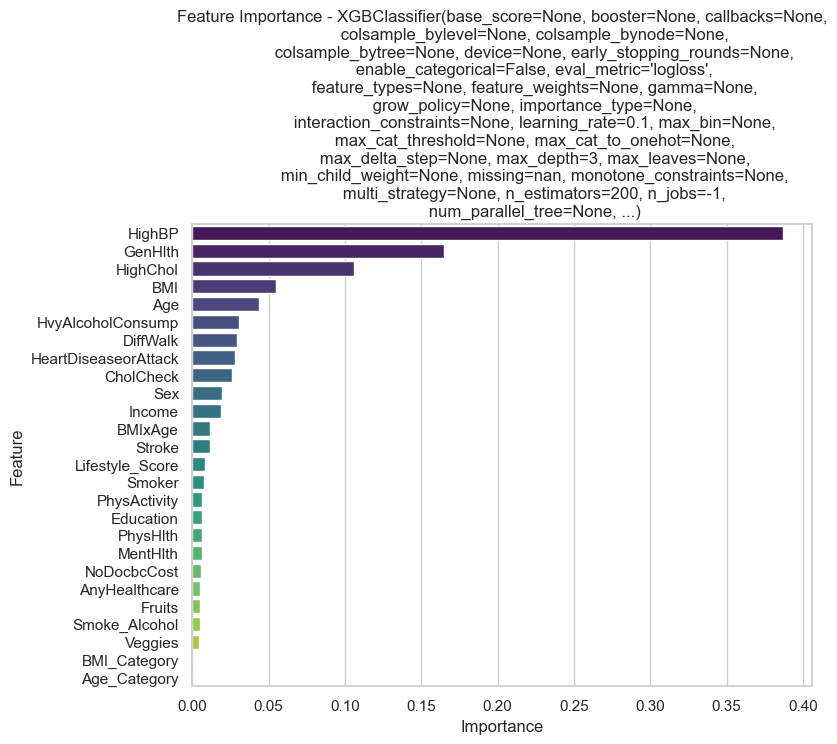


Inference:
    - The top features (like BMI, age, and physical activity) have the highest impact 
      on diabetes risk classification.
    - These insights can guide preventive strategies and patient counseling.
    


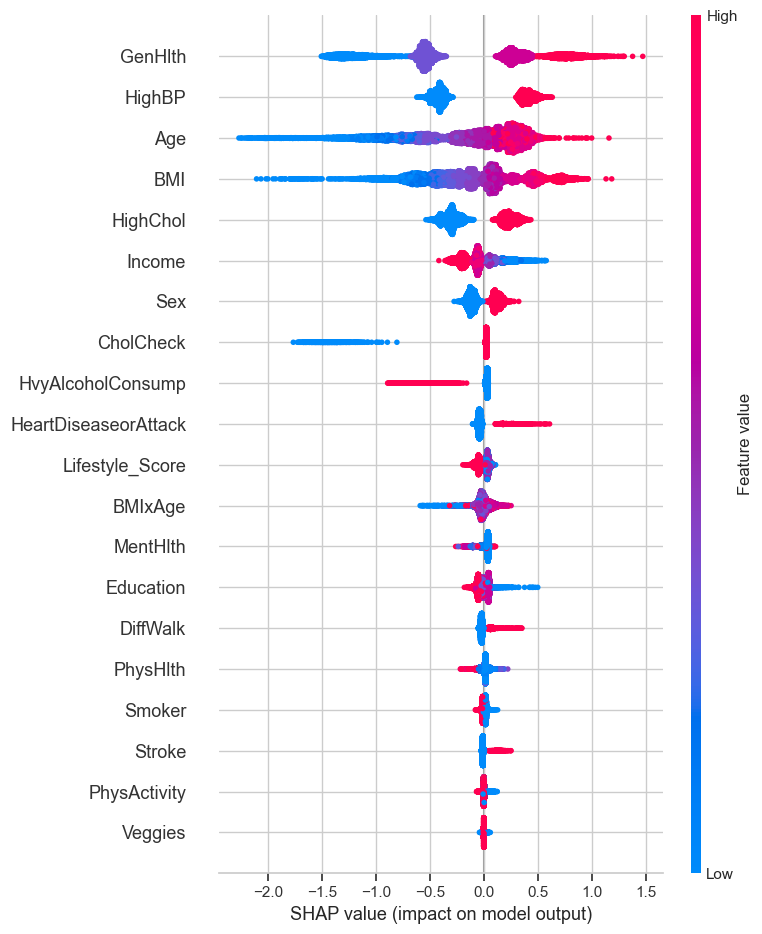

<Figure size 640x480 with 0 Axes>

Saved SHAP summary.


In [37]:
# Feature Importance Plot
feature_importances = best_model.feature_importances_
features = X.columns
fi_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
fi_df = fi_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=fi_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Feature Importance - {best_model}")
plt.show()
# Inference
print("""
Inference:
    - The top features (like BMI, age, and physical activity) have the highest impact 
      on diabetes risk classification.
    - These insights can guide preventive strategies and patient counseling.
    """)
# SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)
plt.savefig(os.path.join(PLOTS_DIR,'SHAP','shap_summary.png')); plt.show()
print('Saved SHAP summary.')

# Final Model saving

In [38]:
# Model saving
import joblib
# select best (prefer tuned if available)
best_est = grid_xgb.best_estimator_ if 'grid_xgb' in globals() else xgb
joblib.dump(best_est, 'final_model.pkl')
print('Saved final_model.pkl')

Saved final_model.pkl


# Day 15 – Interpretation Visuals

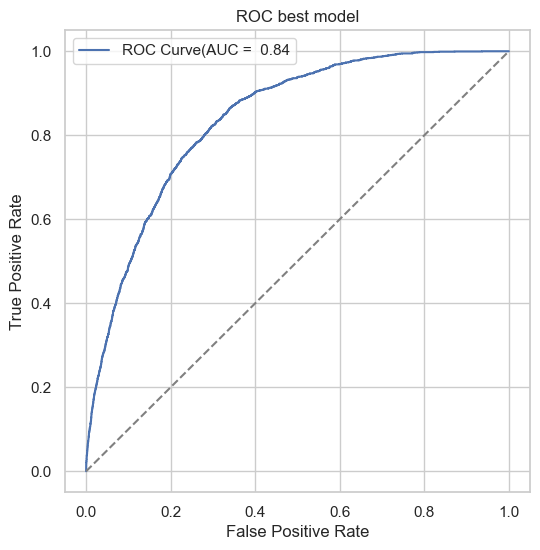

Saved ROC for best model.


In [39]:
# ROC for best and save
best = joblib.load('final_model.pkl')
yprob = best.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yprob)
plt.figure(figsize=(6,6)); plt.plot(fpr,tpr, label= f"ROC Curve(AUC = {roc_auc_score(y_test, y_probs): .2f}"); plt.plot([0,1],[0,1],'--', color= "gray")
plt.title('ROC best model'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
plt.savefig(os.path.join(PLOTS_DIR,'Models','roc_best.png')); plt.show()
print('Saved ROC for best model.')

# Day 16 – SHAP Analysis & Insights

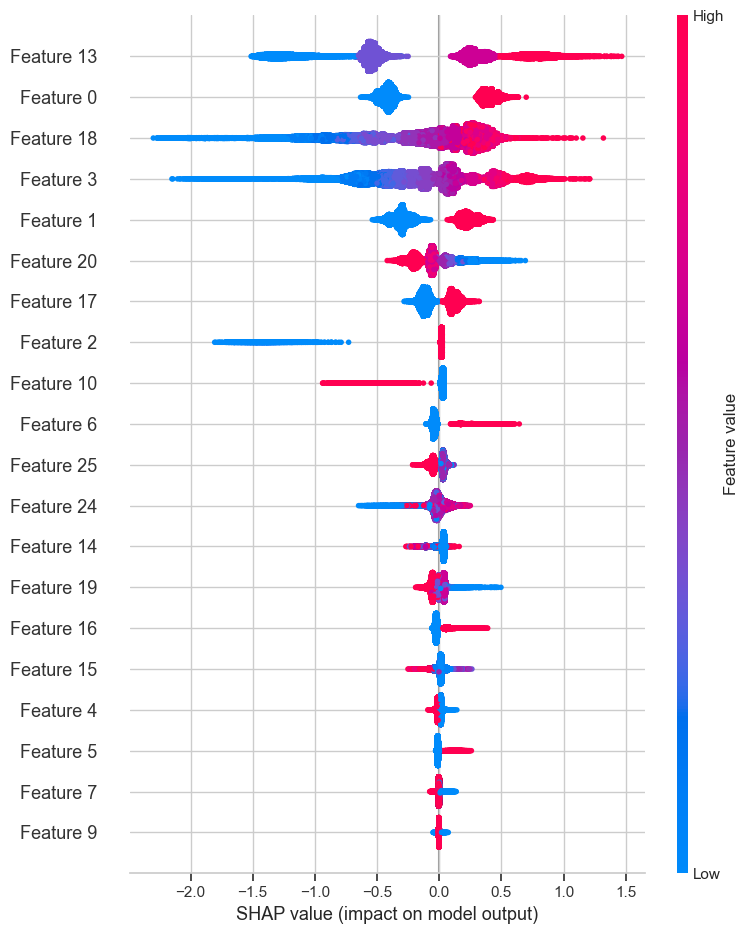

Saved FINAL SHAP summary.


In [40]:

import shap, numpy as np
best = joblib.load('final_model.pkl')
# extract model step if pipeline
if hasattr(best, 'named_steps'):
    pre = best.named_steps['preproc']
    mdl = None
    for k in best.named_steps:
        if k!='preproc': mdl = best.named_steps[k]; break
else:
    pre = None; mdl = best
# prepare data for shap
if pre is not None:
    Xshap = pre.transform(X)
else:
    Xshap = X.select_dtypes(include=['int64','float64']).values
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xshap)
shap.summary_plot(shap_values, Xshap, show=False)
plt.savefig(os.path.join(PLOTS_DIR,'SHAP','best_shap_summary.png')); plt.show()
print('Saved FINAL SHAP summary.')

## 📘 Model saving

In [41]:
# saved random forst model

os.makedirs('../reports_rf', exist_ok=True)
joblib.dump(grid_rf.best_estimator_, '../reports_rf/best_model_rf.joblib')
print('Saved model to ../reports/rf_best_model.joblib')

Saved model to ../reports/rf_best_model.joblib
